### Initialization

In [1]:
import nibabel as nib
from nilearn.image import resample_to_img
from nilearn import plotting
from ipywidgets import interact, widgets
import gmsh
from scipy.io import loadmat
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket
import os

hostname = socket.gethostname()
p = {}
if hostname == 'syndrome' or hostname == 'zod.psych.nyu.edu' or hostname == 'zod':
    p['datd'] = '/d/DATD/datd/MD_TMS_EEG'
else:
    p['datd'] = '/Users/mrugankdake/Documents/Clayspace/EEG_TMS/datd/MD_TMS_EEG'
p['data'] = p['datd'] + '/data'
p['analysis'] = p['datd'] + '/analysis'
p['EEGfiles'] = p['datd'] + '/EEGfiles'
p['meta'] = p['analysis'] + '/meta_analysis'
p['df_fname'] = os.path.join(p['meta'], 'calib_filtered.csv')
p['simnibs_path'] = os.path.join(p['datd'], 'SIMNIBS_output')

# Load up summary data
summary_df = pd.read_csv(os.path.join(p['analysis'] + '/EEG_TMS_meta_Summary.csv'))

All_metadata = {row['Subject ID']: row for _, row in summary_df.iterrows()}
subs = [1, 3, 5, 6, 7, 10, 12, 14, 15, 17, 22, 23, 24, 25, 26, 27]
subs = [1, 3, 5, 6, 7, 10, 12, 14, 15, 17, 22, 23, 25, 26, 27]

stim_intensities = []
hemisphere_stimulated = []
for ss in subs:
    stim_intensities.append(All_metadata[ss]['Stim Intensity'])
    hemisphere_stimulated.append(All_metadata[ss]['Hemisphere stimulated'])
stim_dIdt = [round((a / 60) * 87 *1e6) for a in stim_intensities]


### Functions to load and read anatomicals and ROI

In [2]:
# Function to load nifty
def load_nii_file(fpath, T1):
    nii_img = nib.load(fpath)
    if nii_img.shape[0] != 320:
        nii_img = resample_to_img(fpath, T1, interpolation='nearest')
    data = nii_img.get_fdata()
    return data

# Function to compute average from mask
def calculate_average_over_mask(whole_brain, mask):
    masked_data = whole_brain[mask > 0]
    #print(masked_data.shape)
    average_value = masked_data.max() 
    #########print(average_value)
    return average_value

### Unique to sub24 for whom the ROIs were created using an anatomcial trick, be careful while running this, it overwrites the files

In [6]:
## Create ROIs for sub24
def segregate_rois(roi_path, t1_path, subfoldpath):
    roi_loader = nib.load(t1_path)
    roi_data = load_nii_file(roi_path, t1_path)

    mid_x = roi_data.shape[0] // 2 - 6 # This was found by brute-force search
    
    rois = {'V1': 1, 'V2d': 2, 'V3d': 3, 'V3AB': 4}
    segregated_rois = {roi: {'left': None, 'right': None} for roi in rois}
    
    for roi_name, roi_value in rois.items():
        roi_mask = roi_data == roi_value
        lh = roi_mask.copy()
        rh = roi_mask.copy()
        lh[:mid_x, :, :] = 0
        rh[mid_x:, :, :] = 0
        lh_uint8 = lh.astype(np.uint8)
        rh_uint8 = rh.astype(np.uint8)
        #segregated_rois[roi_name]['left'] = lh
        #segregated_rois[roi_name]['right'] = rh
        lft_img = nib.Nifti1Image(lh_uint8, affine=roi_loader.affine)
        rght_img = nib.Nifti1Image(rh_uint8, affine=roi_loader.affine)
        nib.save(lft_img, f"{subfoldpath}/lh.{roi_name}.nii.gz")
        nib.save(rght_img, f"{subfoldpath}/rh.{roi_name}.nii.gz")
    return segregated_rois

subfoldpath = f"{p['simnibs_path']}/sub24"
t1_path = f"{subfoldpath}/T1.nii"
roi_path = f"{subfoldpath}/ROIs_V1-4-in-volume.nii.gz"
t1_data = load_nii_file(t1_path, t1_path)
roi_total = load_nii_file(roi_path, t1_path)

segregated_rois = segregate_rois(roi_path, t1_path, subfoldpath)

: 

### Visualize the ROIs

In [ ]:
slice_toplot = 140
slice_num = roi_total.shape[0] // 2 -5
t1_plot = t1_data.copy()
#t1_plot[slice_num:, :, :] = 0
#slice_num = slice_num-1
#t1_plot = t1_data

roi_mask = roi_total == 2
plt.figure(figsize=(15, 15))
plt.imshow(t1_plot[:, slice_toplot, :], cmap='gray', origin='lower')
#plt.imshow(roi_mask[:, slice_toplot, :], cmap='hot', alpha=0.5, origin='lower')  # Overlay ROI
#plt.imshow(segregated_rois['V3d']['right'][:, slice_toplot, :], cmap='hot', alpha=0.5, origin='lower')
plt.axhline(y=slice_num)
#plt.title(f"{roi_name} - {hemisphere} Hemisphere")
plt.axis('off')
plt.show()

In [ ]:
slice_x = 1
slice_y = 1
slice_z = 1
def update_plot(slice_x, slice_y, slice_z):
    plt.figure(figsize=(15, 15))
    # Subplot for slice_x
    plt.subplot(131)
    plt.imshow(t1_plot[:, slice_x, :], cmap='gray', origin='lower')
    plt.title(f'Slice X: {slice_x}')
    plt.axis('off')
    # Subplot for slice_y
    plt.subplot(132)
    plt.imshow(t1_plot[slice_y, :, :], cmap='gray', origin='lower')
    plt.title(f'Slice Y: {slice_y}')
    plt.axis('off')
    # Subplot for slice_z
    plt.subplot(133)
    plt.imshow(t1_plot[:, :, slice_z], cmap='gray', origin='lower')
    plt.title(f'Slice Z: {slice_z}')
    plt.axis('off')
    plt.show()
# Create widgets for each slice
slice_x_widget = widgets.IntSlider(min=0, max=t1_data.shape[0] - 1, value=slice_x, description='Slice X:')
slice_y_widget = widgets.IntSlider(min=0, max=t1_data.shape[1] - 1, value=slice_y, description='Slice Y:')
slice_z_widget = widgets.IntSlider(min=0, max=t1_data.shape[2] - 1, value=slice_z, description='Slice Z:')
# Create an interactive plot
interact(update_plot, slice_x=slice_x_widget, slice_y=slice_y_widget, slice_z=slice_z_widget)

### Estimate E-field for each ROI

In [3]:
data = {}
meanarray = {f'T1': [], f'lhV1': [], f'rhV1': [], f'lhV2d': [], f'rhV2d': [],
               f'lhV3d': [], f'rhV3d': [], f'lhV3AB': [], f'rhV3AB': []}
allvalsarray = {f'T1': [], f'lhV1': [], f'rhV1': [], f'lhV2d': [], f'rhV2d': [],
               f'lhV3d': [], f'rhV3d': [], f'lhV3AB': [], f'rhV3AB': []}

for idx, sub in enumerate(subs):
    sub_id = f"sub{sub:02d}"
    metric = "magnE"
    this_hemi = hemisphere_stimulated[idx]

    subfoldpath = f"{p['simnibs_path']}/{sub_id}"
    m2mfoldpath = f"{subfoldpath}/m2m_{sub_id}"
    simfoldpath = f"{subfoldpath}/simstandard/subject_volumes/Targets-0001_MagVenture_Cool-B70_scalar_"
    metricfile = f"{simfoldpath}{metric}.nii.gz"
    sub_init = All_metadata[sub]['Subject Initials']
    
    if this_hemi ==  'Left':
        file_paths = {
            'T1': f"{subfoldpath}/T1.nii",
            'lhV1': f"{subfoldpath}/lh.V1.nii.gz",
            'rhV1': f"{subfoldpath}/rh.V1.nii.gz",
            'lhV2d': f"{subfoldpath}/lh.V2d.nii.gz",
            'rhV2d': f"{subfoldpath}/rh.V2d.nii.gz",
            'lhV3d': f"{subfoldpath}/lh.V3d.nii.gz",
            'rhV3d': f"{subfoldpath}/rh.V3d.nii.gz",
            'lhV3AB': f"{subfoldpath}/lh.V3AB.nii.gz",
            'rhV3AB': f"{subfoldpath}/rh.V3AB.nii.gz"
        }
    else:
        file_paths = {
            'T1': f"{subfoldpath}/T1.nii",
            'lhV1': f"{subfoldpath}/rh.V1.nii.gz",
            'rhV1': f"{subfoldpath}/lh.V1.nii.gz",
            'lhV2d': f"{subfoldpath}/rh.V2d.nii.gz",
            'rhV2d': f"{subfoldpath}/lh.V2d.nii.gz",
            'lhV3d': f"{subfoldpath}/rh.V3d.nii.gz",
            'rhV3d': f"{subfoldpath}/lh.V3d.nii.gz",
            'lhV3AB': f"{subfoldpath}/rh.V3AB.nii.gz",
            'rhV3AB': f"{subfoldpath}/lh.V3AB.nii.gz"
        }

    data[sub_id] = {roi_name: load_nii_file(path, file_paths['T1'])
                    for roi_name, path in file_paths.items()}
    metric_data = load_nii_file(metricfile, file_paths['T1'])

    if sub == 12:
        funcFitpath = f"/d/DATA/data/pRF_subjects/{sub_init}/RF1/{sub_init}_RF1_vista/Inplane/Original/RF_ss5_25mm-fFit.nii.gz"
    elif sub == 26: 
        funcFitpath = f"/d/DATA/data/pRF_subjects/{sub_init}/RF1/{sub_init}_RF1_vista/Inplane/Original/RF_ss5_25mm-fFit.nii.gz"
    else:
        funcFitpath = f"/d/DATA/data/pRF_subjects/{sub_init}/RF1/{sub_init}_RF1_vista/Inplane/Original/RF_ss5-fFit.nii.gz"
    funcFitdata = load_nii_file(funcFitpath, file_paths['T1'])

    ve_thresh = 0.1
    bad_voxels = np.where(funcFitdata[:, :, :, 1] < ve_thresh)
    polmap_data = funcFitdata[:, :, :, 0]
    polmap_data[bad_voxels] = np.nan
    polmap_data = np.rad2deg(polmap_data)

    # Change the polar angle coordinate space to match the coordinate space used in behavior
    polmap_data[(polmap_data>=0) & (polmap_data<=180)] = -polmap_data[(polmap_data>=0) & (polmap_data<=180)]
    polmap_data[(polmap_data>180) & (polmap_data<360)] = 360-polmap_data[(polmap_data>180) & (polmap_data<360)]
    polmap_data_flat = polmap_data.flatten()
    
    for roi_name, path in file_paths.items():
        roi_data = load_nii_file(path, f"{subfoldpath}/T1.nii")
        old_sum = np.sum(roi_data)
        mask = np.ones_like(polmap_data, dtype=bool)
        if this_hemi ==  'Left':
            if roi_name in ['lhV1', 'lhV2d', 'lhV3d', 'lhV3AB']:
                mask &= (polmap_data <= 0) & (polmap_data >= -90)
            else:
                mask &= (polmap_data >= -180) & (polmap_data <= -90)
        else:
            if roi_name in ['rhV1', 'rhV2d', 'rhV3d', 'rhV3AB']:
                mask &= (polmap_data <= 0) & (polmap_data >= -90)
            else:
                mask &= (polmap_data >= -180) & (polmap_data <= -90)
        
        roi_data[~mask] = 0
        new_sum = np.sum(roi_data)
        if new_sum != old_sum:
            print(f"Sum of ROI {roi_name} changed from {old_sum} to {new_sum} for subject {sub_id}")
        # if roi_name == 'lhV1' or roi_name == 'lhV2d' or roi_name == 'lhV3d' or roi_name == 'lhV3AB':
        #     roi_data = roi_data[polmap_data < 0]
        #     roi_data = roi_data[polmap_data > -90]
        # else:
        #     roi_data = roi_data[polmap_data < -90]
        #     roi_data = roi_data[polmap_data > -180]
        allvalsarray[roi_name].extend(metric_data[roi_data>0].flatten())
        mean_value = calculate_average_over_mask(metric_data, roi_data)
        meanarray[roi_name].append(mean_value)

Sum of ROI T1 changed from 723614385.0 to 5682681.0 for subject sub01
Sum of ROI lhV1 changed from 17102.0 to 8914.0 for subject sub01
Sum of ROI rhV1 changed from 13841.0 to 7183.0 for subject sub01
Sum of ROI lhV2d changed from 9396.0 to 9006.0 for subject sub01
Sum of ROI rhV2d changed from 8357.0 to 7026.0 for subject sub01
Sum of ROI lhV3d changed from 7668.0 to 7151.0 for subject sub01
Sum of ROI rhV3d changed from 8159.0 to 7528.0 for subject sub01
Sum of ROI lhV3AB changed from 12188.0 to 6739.0 for subject sub01
Sum of ROI rhV3AB changed from 13185.0 to 5804.0 for subject sub01


/users/mrugank/.conda/envs/eegmne/lib/python3.12/site-packages/nilearn/image/resampling.py:664: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(


Sum of ROI T1 changed from 683475727.0 to 12322026.0 for subject sub03
Sum of ROI lhV1 changed from 14301.0 to 12527.0 for subject sub03
Sum of ROI rhV1 changed from 15896.0 to 7471.0 for subject sub03
Sum of ROI lhV2d changed from 6065.0 to 5601.0 for subject sub03
Sum of ROI rhV2d changed from 7373.0 to 7023.0 for subject sub03
Sum of ROI lhV3d changed from 4541.0 to 4262.0 for subject sub03
Sum of ROI rhV3d changed from 5827.0 to 5631.0 for subject sub03
Sum of ROI lhV3AB changed from 8924.0 to 5603.0 for subject sub03
Sum of ROI rhV3AB changed from 13223.0 to 7893.0 for subject sub03
Sum of ROI T1 changed from 751937151.0 to 20761716.0 for subject sub05
Sum of ROI lhV1 changed from 20981.0 to 10079.0 for subject sub05
Sum of ROI rhV1 changed from 16161.0 to 7527.0 for subject sub05
Sum of ROI lhV2d changed from 7954.0 to 6774.0 for subject sub05
Sum of ROI rhV2d changed from 7114.0 to 6236.0 for subject sub05
Sum of ROI lhV3d changed from 7233.0 to 6790.0 for subject sub05
Sum of R

/users/mrugank/.conda/envs/eegmne/lib/python3.12/site-packages/nilearn/image/resampling.py:664: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(


Sum of ROI T1 changed from 769913971.0 to 8278972.0 for subject sub12
Sum of ROI lhV1 changed from 28482.0 to 7960.0 for subject sub12
Sum of ROI rhV1 changed from 19145.0 to 7842.0 for subject sub12
Sum of ROI lhV2d changed from 15790.0 to 11902.0 for subject sub12
Sum of ROI rhV2d changed from 22818.0 to 17424.0 for subject sub12
Sum of ROI lhV3d changed from 22623.0 to 18945.0 for subject sub12
Sum of ROI rhV3d changed from 20286.0 to 17211.0 for subject sub12
Sum of ROI lhV3AB changed from 78550.0 to 24870.0 for subject sub12
Sum of ROI rhV3AB changed from 92205.0 to 32060.0 for subject sub12
Sum of ROI T1 changed from 681371966.0 to 9071181.0 for subject sub14
Sum of ROI lhV1 changed from 20592.0 to 9259.0 for subject sub14
Sum of ROI rhV1 changed from 23207.0 to 10149.0 for subject sub14
Sum of ROI lhV2d changed from 8316.0 to 7943.0 for subject sub14
Sum of ROI rhV2d changed from 5103.0 to 4986.0 for subject sub14
Sum of ROI lhV3d changed from 6748.0 to 6706.0 for subject sub14


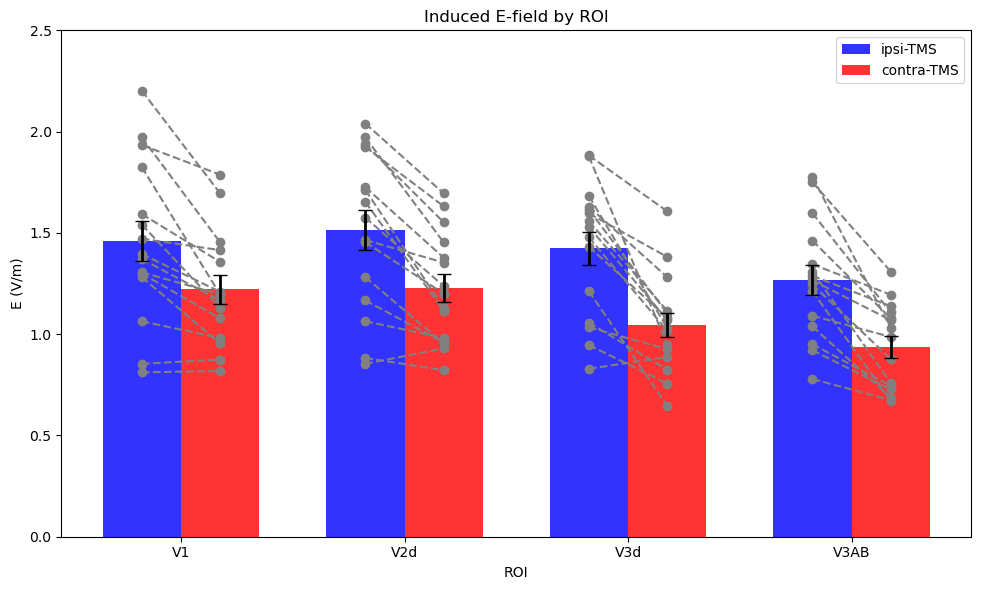

In [4]:
means = {roi: np.mean(values) for roi, values in meanarray.items()}
std_errors = {roi: np.std(values) / np.sqrt(len(values)) for roi, values in meanarray.items()}
roi_list = ['V1', 'V2d', 'V3d', 'V3AB']

fig, ax = plt.subplots(figsize=(10, 6))
n_groups = len(means) // 2
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

for i, roi in enumerate(roi_list):
    lh_mean = meanarray[f'lh{roi}']
    rh_mean = meanarray[f'rh{roi}']
    lh_x = index[i] - bar_width/2
    rh_x = lh_x + bar_width
    ax.plot([lh_x + bar_width/2, rh_x + bar_width/2], [lh_mean, rh_mean], 'grey', linestyle='--', marker='o')

left_bars = ax.bar(index, [means[f'lh{roi}'] for roi in roi_list],
                   bar_width, alpha=opacity, color='b',
                   yerr=[std_errors[f'lh{roi}'] for roi in roi_list],
                   label='ipsi-TMS', error_kw={'elinewidth':2, 'capsize':5})

right_bars = ax.bar(index + bar_width, [means[f'rh{roi}'] for roi in roi_list],
                    bar_width, alpha=opacity, color='r',
                    yerr=[std_errors[f'rh{roi}'] for roi in roi_list],
                    label='contra-TMS', error_kw={'elinewidth':2, 'capsize':5})
ax.set_xlabel('ROI')
ax.set_ylabel('E (V/m)')
ax.set_title('Induced E-field by ROI')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(roi_list)
ax.legend()

# Adding a grid, setting the limit and making layout tight
#ax.yaxis.grid(True)
ax.set_ylim([0, max(means.values()) + max(std_errors.values()) * 3])  # Adjust the y-axis limit to show error bars
plt.tight_layout()
plt.ylim([0, 2.5])
# Show the plot
# plt.savefig('/d/DATA/hyper/manuscripts/Dake_Curtis_2024/efield_induced_by_roi.eps', format = 'eps', dpi = 1200)
plt.show()

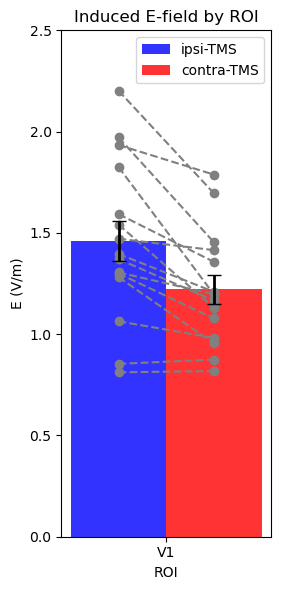

In [5]:
roi_V1_list = ['V1']

fig, ax = plt.subplots(figsize=(3, 6))
n_groups = 1 #len(means) // 2
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

for i, roi in enumerate(roi_V1_list):
    lh_mean = meanarray[f'lh{roi}']
    rh_mean = meanarray[f'rh{roi}']
    lh_x = index[i] - bar_width/2
    rh_x = lh_x + bar_width
    ax.plot([lh_x + bar_width/2, rh_x + bar_width/2], [lh_mean, rh_mean], 'grey', linestyle='--', marker='o')

left_bars = ax.bar(index, [means[f'lh{roi}'] for roi in roi_V1_list],
                   bar_width, alpha=opacity, color='b',
                   yerr=[std_errors[f'lh{roi}'] for roi in roi_V1_list],
                   label='ipsi-TMS', error_kw={'elinewidth':2, 'capsize':5})

right_bars = ax.bar(index + bar_width, [means[f'rh{roi}'] for roi in roi_V1_list],
                    bar_width, alpha=opacity, color='r',
                    yerr=[std_errors[f'rh{roi}'] for roi in roi_V1_list],
                    label='contra-TMS', error_kw={'elinewidth':2, 'capsize':5})
ax.set_xlabel('ROI')
ax.set_ylabel('E (V/m)')
ax.set_title('Induced E-field by ROI')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(roi_V1_list)
ax.legend()

# Adding a grid, setting the limit and making layout tight
#ax.yaxis.grid(True)
ax.set_ylim([0, max(means.values()) + max(std_errors.values()) * 3])  # Adjust the y-axis limit to show error bars
plt.tight_layout()
plt.ylim([0, 2.5])
# Show the plot
# plt.savefig('/d/DATA/hyper/manuscripts/Dake_Curtis_2024/efield_induced_by_roi_justV1.eps', format = 'eps', dpi = 1200)
plt.show()

In [9]:
from scipy.stats import ttest_rel
for roi in roi_list:
    t, p = ttest_rel(meanarray[f'lh{roi}'], meanarray[f'rh{roi}'])
    print(f"t-test for ROI {roi}: t = {t}, df = {len(meanarray[f'lh{roi}']) - 1}, p = {p}")

t-test for ROI V1: t = 4.677244337941889, df = 14, p = 0.0003562054172229607
t-test for ROI V2d: t = 5.959966563485253, df = 14, p = 3.48707987121655e-05
t-test for ROI V3d: t = 6.104001538070855, df = 14, p = 2.7238933029790035e-05
t-test for ROI V3AB: t = 6.619208612148705, df = 14, p = 1.152610440950919e-05


### Find the outlier subjects with higher E-field in contralateral ROI

In [ ]:
for i, roi in enumerate(roi_list):
    for jj in range(len(subs)):
        sub_id = subs[jj]
        #meanarray[roi_name]
        lh_mean = meanarray[f'lh{roi}'][jj]
        rh_mean = meanarray[f'rh{roi}'][jj]
        if rh_mean > lh_mean:
            print(subs[jj], roi, lh_mean, rh_mean)

### Visualize histograms of E-field by voxels in ROIs

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (10, 10))
ax[0].hist(allvalsarray['lhV1'], bins = 100, range = (0.1, 2))
ax[1].hist(allvalsarray['rhV1'], bins = 100, range = (0.1, 2))
ax[0].set_title('lhV1')
ax[1].set_title('rhV1')
# ax[0].set_ylim([0, 500])
# ax[1].set_ylim([0, 500])
ax[0].set_xlabel('E (V/m)')
ax[1].set_xlabel('E (V/m)')
#plt.savefig('/d/DATA/hyper/conferences/Dake_SfN2023/hist_efield_V1_sub01.eps', format = 'eps', dpi = 1200)
plt.show()
#plt.xlim([0.1, 1])

### Check if E-field induced depends on the size of the ROI

In [ ]:
sizearray = {f'T1': [], f'lhV1': [], f'rhV1': [], f'lhV2d': [], f'rhV2d': [],
               f'lhV3d': [], f'rhV3d': [], f'lhV3AB': [], f'rhV3AB': []}
Efieldarray = {f'T1': [], f'lhV1': [], f'rhV1': [], f'lhV2d': [], f'rhV2d': [],
               f'lhV3d': [], f'rhV3d': [], f'lhV3AB': [], f'rhV3AB': []}
normalized_size = {f'T1': [], f'lhV1': [], f'rhV1': [], f'lhV2d': [], f'rhV2d': [],
               f'lhV3d': [], f'rhV3d': [], f'lhV3AB': [], f'rhV3AB': []}
roi_list = ['T1', 'lhV1', 'rhV1', 'lhV2d', 'rhV2d', 'lhV3d', 'rhV3d', 'lhV3AB', 'rhV3AB']
for idx, sub in enumerate(subs):
    sub = subs[idx]
    sub_id = f"sub{sub:02d}"
    for roi_name in roi_list:
        sizearray[roi_name].append(np.sum(data[sub_id][roi_name]))
        Efieldarray[roi_name].append(meanarray[roi_name][idx])
        normalized_size[roi_name].append(np.mean(data[sub_id][roi_name]))

In [ ]:
fig, axs = plt.subplots(3, 3, figsize = (10, 10))
axs = axs.flatten()
for ax, roi_name in zip(axs, roi_list):
    this_x = [normalized_size[roi_name]]
    this_y = [Efieldarray[roi_name]]
    ax.scatter(this_x, this_y)
    ax.set_title(roi_name)
    ax.set_xlabel('Relative Size')
    ax.set_ylabel('E-field')
plt.tight_layout()
plt.show()

### Load up behavioral data

In [ ]:
df_calib_filt = pd.read_csv('/d/DATD/datd/MD_TMS_EEG/analysis/meta_analysis/calib_filtered.csv')
df_calib_all5_filt = pd.read_csv('/d/DATD/datd/MD_TMS_EEG/analysis/meta_analysis/calib_all5_filtered.csv')

In [ ]:
from scipy.stats import circmean

In [ ]:
## Debugging
temp_subs = [1, 3, 5, 6, 7, 10, 12, 14, 15, 17, 22, 23, 25, 26, 27]
sess = [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
loc = [1, 2, 8, 3, 4, 6, 4, 6, 5, 2, 6, 3, 4, 1, 4]

n_subs = len(temp_subs)

# temp_subs = [1, 3]
resolution = 100
Efield_holder = np.zeros((len(temp_subs), resolution-1))
polang_range_holder = np.zeros((len(temp_subs), ))
diff_holder = np.zeros((len(temp_subs), ))
centroid_holder = np.zeros((len(temp_subs), ))
#fig, axs = plt.subplots(n_subs, 2, figsize=(10, 5 * n_subs))
for idx, sub in enumerate(temp_subs):
    sub_id = f"sub{sub:02d}"
    metric = "magnE"
    this_hemi = hemisphere_stimulated[idx]

    subfoldpath = f"{p['simnibs_path']}/{sub_id}"
    m2mfoldpath = f"{subfoldpath}/m2m_{sub_id}"
    simfoldpath = f"{subfoldpath}/simstandard/subject_volumes/Targets-0001_MagVenture_Cool-B70_scalar_"
    metricfile = f"{simfoldpath}{metric}.nii.gz"
    sub_init = All_metadata[sub]['Subject Initials']
    if sub == 12:
        funcFitpath = f"/d/DATA/data/pRF_subjects/{sub_init}/RF1/{sub_init}_RF1_vista/Inplane/Original/RF_ss5_25mm-fFit.nii.gz"
    elif sub == 26: 
        funcFitpath = f"/d/DATA/data/pRF_subjects/{sub_init}/RF1/{sub_init}_RF1_vista/Inplane/Original/RF_ss5_25mm-fFit.nii.gz"
    else:
        funcFitpath = f"/d/DATA/data/pRF_subjects/{sub_init}/RF1/{sub_init}_RF1_vista/Inplane/Original/RF_ss5-fFit.nii.gz"
        
    if this_hemi ==  'Left':
        file_paths = {
            'T1': f"{subfoldpath}/T1.nii",
            'lhV1': f"{subfoldpath}/lh.V1.nii.gz",
            'rhV1': f"{subfoldpath}/rh.V1.nii.gz",
            'lhV2d': f"{subfoldpath}/lh.V2d.nii.gz",
            'rhV2d': f"{subfoldpath}/rh.V2d.nii.gz",
            'lhV3d': f"{subfoldpath}/lh.V3d.nii.gz",
            'rhV3d': f"{subfoldpath}/rh.V3d.nii.gz",
            'lhV3AB': f"{subfoldpath}/lh.V3AB.nii.gz",
            'rhV3AB': f"{subfoldpath}/rh.V3AB.nii.gz"
        }
    else:
        file_paths = {
            'T1': f"{subfoldpath}/T1.nii",
            'lhV1': f"{subfoldpath}/rh.V1.nii.gz",
            'rhV1': f"{subfoldpath}/lh.V1.nii.gz",
            'lhV2d': f"{subfoldpath}/rh.V2d.nii.gz",
            'rhV2d': f"{subfoldpath}/lh.V2d.nii.gz",
            'lhV3d': f"{subfoldpath}/rh.V3d.nii.gz",
            'rhV3d': f"{subfoldpath}/lh.V3d.nii.gz",
            'lhV3AB': f"{subfoldpath}/rh.V3AB.nii.gz",
            'rhV3AB': f"{subfoldpath}/lh.V3AB.nii.gz"
        }
    
    funcFitdata = load_nii_file(funcFitpath, file_paths['T1'])
    # Remove voxels below variance-explained threshold of 0.1
    ve_thresh = 0.1
    bad_voxels = np.where(funcFitdata[:, :, :, 1] < ve_thresh)
    polmap_data = funcFitdata[:, :, :, 0]
    polmap_data[bad_voxels] = np.nan
    polmap_data = np.rad2deg(polmap_data)

    # Change the polar angle coordinate space to match the coordinate space used in behavior
    polmap_data[(polmap_data>=0) & (polmap_data<=180)] = -polmap_data[(polmap_data>=0) & (polmap_data<=180)]
    polmap_data[(polmap_data>180) & (polmap_data<360)] = 360-polmap_data[(polmap_data>180) & (polmap_data<360)]

    # polmap_data[(polmap_data>=0) & (polmap_data<=180)] = -polmap_data[(polmap_data>=0) & (polmap_data<=180)]
    # polmap_data[(polmap_data>180) & (polmap_data<360)] = -(360-polmap_data[(polmap_data>180) & (polmap_data<360)])
    #t1_data = nib.load(t1_path).get_fdata()
    metric_data = load_nii_file(metricfile, file_paths['T1'])
    lhV1_data = load_nii_file(file_paths['lhV1'], file_paths['T1'])
    rhV1_data = load_nii_file(file_paths['rhV1'], file_paths['T1'])
    lhV2d_data = load_nii_file(file_paths['lhV2d'], file_paths['T1'])
    rhV2d_data = load_nii_file(file_paths['rhV2d'], file_paths['T1'])
    lhV3d_data = load_nii_file(file_paths['lhV3d'], file_paths['T1'])
    rhV3d_data = load_nii_file(file_paths['rhV3d'], file_paths['T1'])
    lhV3AB_data = load_nii_file(file_paths['lhV3AB'], file_paths['T1'])
    rhV3AB_data = load_nii_file(file_paths['rhV3AB'], file_paths['T1'])
    totalV_data = ((lhV1_data == 1) | (rhV1_data == 1)).astype(int)
    # totalV_data = ((lhV2d_data == 1) | (rhV2d_data == 1) | (lhV3d_data == 1) | (rhV3d_data == 1)).astype(int)
    normalize_Efield = metric_data/metric_data.max()

    polmap_data_flat = polmap_data.flatten()
    totalV_data_flat = totalV_data.flatten() 
    polmap_data_flat[totalV_data_flat != 1] = np.nan
    normalize_Efield_flat = normalize_Efield.flatten()
    valid_indices = ~np.isnan(polmap_data_flat)
    polmap_data_valid = polmap_data_flat[valid_indices]
    normalize_Efield_valid = normalize_Efield_flat[valid_indices]

    # polar_angle_bins = np.linspace(min(polmap_data_valid), max(polmap_data_valid), num=resolution)  
    #polar_angle_bins = np.linspace(0, 360, num=resolution)
    polar_angle_bins = np.linspace(-180, 180, num=resolution)
    polar_angle_bin_indices = np.digitize(polmap_data_valid, polar_angle_bins)

    # Calculate the mean E-field magnitude for each bin
    mean_efield_per_bin = np.array([normalize_Efield_valid[polar_angle_bin_indices == i].mean() for i in range(1, len(polar_angle_bins))])
    mean_efield_per_bin = np.nan_to_num(mean_efield_per_bin)
    bin_middles = (polar_angle_bins[:-1] + polar_angle_bins[1:]) / 2
    x_plot = mean_efield_per_bin * np.cos(np.deg2rad(bin_middles))
    y_plot = mean_efield_per_bin * np.sin(np.deg2rad(bin_middles))

    df_tms = df_calib_all5_filt[(df_calib_all5_filt['subjID']==sub) & (df_calib_all5_filt['day']<4) & (df_calib_all5_filt['istms']==1) & (df_calib_all5_filt['ispro']==1) ]
    
    tms_polang = np.rad2deg(df_tms[df_tms['instimVF']==1]['polang'])
    tms_polang_out = np.rad2deg(df_tms[df_tms['instimVF']==0]['polang'])

    tms_centroid = circmean(tms_polang, high=180, low=-180)
    centroid_holder[idx] = tms_centroid
    tms_centroid_out = circmean(tms_polang_out, high=180, low=-180)
    diff_holder[idx] = np.abs(tms_centroid - tms_centroid_out)

    if tms_polang.max() > 0 and tms_polang.max() < 90:
        polang_range_holder[idx] = tms_polang.max() - tms_polang.min()
    elif tms_polang.max() < 0:
        polang_range_holder[idx] = tms_polang.max() - tms_polang.min()
    elif tms_polang.max() > 90:
        polang_range_holder[idx] = (180-min(tms_polang[tms_polang > 0])) + (180-abs(max(tms_polang[tms_polang < 0])))
    
    # # rotation_amount = np.round(angle_diffs)
    # angle_diff = bin_middles - tms_centroid
    # bin_median = np.where(angle_diff<0)

    # rotation_amount = np.round(angle_diffs)
    # angle_diff = bin_middles - tms_centroid
    # bin_median = np.where(angle_diff>0)

    # Rotate the E-field vector so that the TMS centroid is at 0 degrees
    # The key is to mkae sure that the rotation is always in one direction
    #rotate_amount = int(resolution/2)-bin_median[0][0]

    rotate_amount = np.where(bin_middles>=tms_centroid)[0][0]
    where0 = np.where(bin_middles>=0)[0][0]
    rotate_amount = where0-rotate_amount
    temp_Efield = np.roll(mean_efield_per_bin, rotate_amount, axis = 0)
    # y_rot = np.roll(y, abs(rotate_amount))

    # rotate_amount = np.where(bin_middles>=tms_centroid)[0][0]
    # # x_rot = x + rotate_ang
    # # y_rot = np.roll(y, int(res/2)-rotate_ang)

    # # rotate_amount = 37 - bin_median[0][0]
    # temp_Efield = np.roll(mean_efield_per_bin, rotate_amount, axis = 0)
    # But np.roll can create cases where rotation is clockwise or anticlockwise
    # So we need to check if the rotation is clockwise or anticlockwise
    if rotate_amount < 0:
        print(sub_id, rotate_amount)
        temp_Efield = np.flip(temp_Efield)
    
    if df_tms['hemistimulated'].unique()[0] == 'Right':
        temp_Efield = np.flip(temp_Efield)

    # Rotate to -45
    where45 = np.where(bin_middles>=-18)[0][0]
    rotate_amount = where45-where0
    temp_Efield = np.roll(temp_Efield, rotate_amount, axis = 0)
    Efield_holder[idx, :] = temp_Efield

/users/mrugank/.conda/envs/eegmne/lib/python3.12/site-packages/nilearn/image/resampling.py:664: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(
/var/folders/cf/d9j3_ppd5wb4bn9y_fgj3nb800010l/T/ipykernel_64201/2274326538.py:99: RuntimeWarning: Mean of empty slice.
  mean_efield_per_bin = np.array([normalize_Efield_valid[polar_angle_bin_indices == i].mean() for i in range(1, len(polar_angle_bins))])
/users/mrugank/.conda/envs/eegmne/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/users/mrugank/.conda/envs/eegmne/lib/python3.12/site-packages/nilearn/image/resampling.py:664: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(
/var/fol

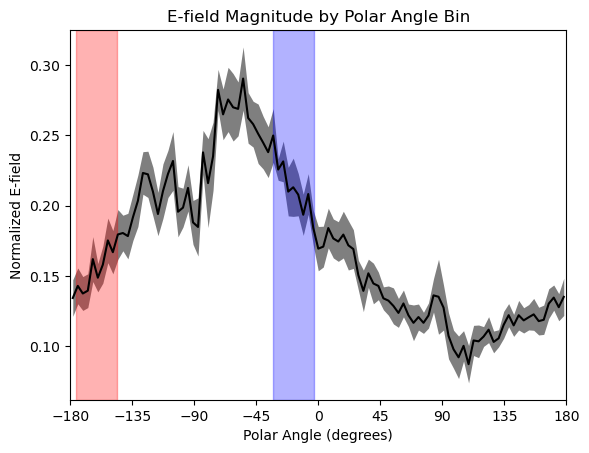

In [ ]:
plt.figure()
y = np.mean(Efield_holder, 0)
y_err = np.nanstd(Efield_holder, 0)/np.sqrt(len(temp_subs))
plt.plot(bin_middles, y, 'k')
scale_to = -18
plt.fill_between(bin_middles, y-y_err, y+y_err, alpha=0.5, linewidth=0, color='k')
plt.axvspan(scale_to-np.mean(polang_range_holder)/2, scale_to+np.mean(polang_range_holder)/2, color='blue', alpha=0.3)
plt.axvspan(scale_to-np.mean(diff_holder)-np.mean(polang_range_holder)/2, scale_to-np.mean(diff_holder)+np.mean(polang_range_holder)/2, color='red', alpha=0.3)
plt.xlabel('Polar Angle (degrees)')
plt.ylabel('Normalized E-field')
plt.xlim([-180, 180])
plt.xticks([-180, -135, -90, -45, 0, 45, 90, 135, 180])
plt.title('E-field Magnitude by Polar Angle Bin')
# plt.savefig('/d/DATA/hyper/manuscripts/Dake_Curtis_2024/predicted_efield_peak.eps', format = 'eps', dpi = 1200)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


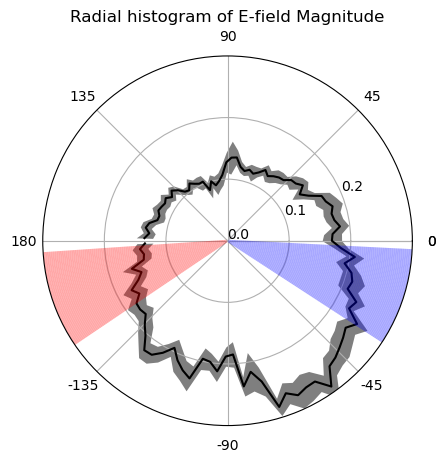

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

max_radius = 0.3
theta = np.radians(bin_middles)
ax.plot(theta, y, color='k')
ax.fill_between(theta, y-y_err, y+y_err, alpha=0.5, linewidth=0, color='k')
# angle_range1 = np.radians([360-np.max(polang_range_holder)/2, 0+np.max(polang_range_holder)/2])
# angle_range2 = np.radians([-np.mean(diff_holder)-np.max(polang_range_holder)/2, -np.mean(diff_holder)+np.max(polang_range_holder)/2])
scale_to = -18

angle_range1 = np.linspace(np.radians(scale_to-np.mean(polang_range_holder)/2), np.radians(scale_to+np.mean(polang_range_holder)/2), 100)
filler_space = np.linspace(0, max_radius, 100)
angle_range2 = np.linspace(np.radians(scale_to-np.mean(diff_holder)-np.mean(polang_range_holder)/2), np.radians(scale_to-np.mean(diff_holder)+np.mean(polang_range_holder)/2), 100)
for ii in range(len(filler_space)):
    ax.plot(angle_range1, filler_space[ii]*np.ones(100,), color='b', alpha=0.3)
for ii in range(len(filler_space)):
    ax.plot(angle_range2, filler_space[ii]*np.ones(100,), color='r', alpha=0.3)

# ax.set_ylim(0, max(y+y_err))
ax.set_ylim(0, max_radius)
# ax.set_yticks(np.arange(0, max(y+y_err)+0.1, 0.1))
ax.set_yticks(np.arange(0, max_radius, 0.1))
# ax.set_yticklabels([str(round(y, 1)) for y in np.arange(0, max(y+y_err)+0.1, 0.1)])
ax.set_yticklabels([str(round(y, 1)) for y in np.arange(0, max_radius, 0.1)])

ax.set_xticks(np.radians([0, 45, 90, 135, 180, 225, 270, 315, 360]))
ax.set_xticklabels(['0', '45', '90', '135', '180', '-135', '-90', '-45', '0'])

ax.set_title('Radial histogram of E-field Magnitude')
plt.savefig('/d/DATA/hyper/manuscripts/Dake_Curtis_2024/predicted_efield_phosphene_radial.eps', format = 'eps', dpi = 1200)
plt.show()

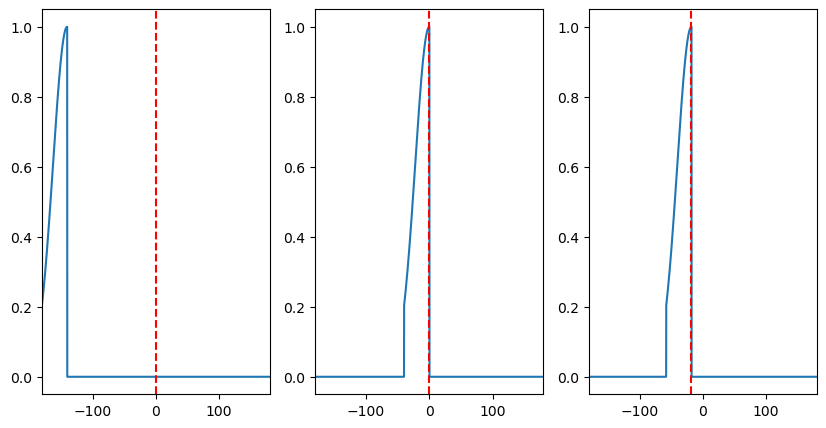

In [ ]:
# Simulate a gaussian and try to rotate the vector
res = 10000
x = np.linspace(-180, 180, res)
c = -140
align_at = 0
# Let's simulate an asymmetric gaussian
y = np.exp(-(x-c)**2/1000)
y[x>c] = 0

# y = np.exp(-(x-c)**2/100)

rotate_ang = np.where(x>=c)[0][0]
where0 = np.where(x>=align_at)[0][0]
rotate_amount = where0-rotate_ang
# x_rot = x + rotate_ang
y_rot = np.roll(y, abs(rotate_amount))

where45 = np.where(x>=-18)[0][0]
rotate2_amount = where45-where0
y_rot2 = np.roll(y_rot, rotate2_amount)
if rotate_amount < 0:
    y_rot = np.flip(y_rot)
f, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].plot(x, y)
ax[0].set_xlim([-180, 180])
ax[0].axvline(align_at, color='r', linestyle='--')
ax[1].plot(x, y_rot)
ax[1].set_xlim([-180, 180])
ax[1].axvline(align_at, color='r', linestyle='--')
ax[2].plot(x, y_rot2)
ax[2].set_xlim([-180, 180])
ax[2].axvline(-18, color='r', linestyle='--')
plt.show()

## Creating an estimate of pRF field from voxels

In [ ]:
temp_subs = [1, 3, 5, 6, 7, 10, 12, 14, 15, 17, 22, 23, 25, 26, 27]

n_subs = len(temp_subs)

# temp_subs = [1, 3]
resolution = 100

lhV1_pRF_estimate = np.zeros((50, 50))
rhV1_pRF_estimate = np.zeros((50, 50))
lhV1bottom_pRF_estimate = np.zeros((50, 50))
rhV1bottom_pRF_estimate = np.zeros((50, 50))
# lhV2d_pRF_estimate = np.zeros((50, 50))
# lhV3d_pRF_estimate = np.zeros((50, 50))
# lhV3AB_pRF_estimate = np.zeros((50, 50))

# rhV2d_pRF_estimate = np.zeros((50, 50))
# rhV3d_pRF_estimate = np.zeros((50, 50))
# rhV3AB_pRF_estimate = np.zeros((50, 50))
lhv1_vox_count = 0
rhv1_vox_count = 0
lhv1bottom_vox_count = 0
rhv1bottom_vox_count = 0
# lhv2d_vox_count = 0
# rhv2d_vox_count = 0
# lhv3d_vox_count = 0
# rhv3d_vox_count = 0
# lhv3ab_vox_count = 0
# rhv3ab_vox_count = 0
#fig, axs = plt.subplots(n_subs, 2, figsize=(10, 5 * n_subs))
for idx, sub in enumerate(temp_subs):
    sub_id = f"sub{sub:02d}"
    print("We are now running subject ", sub_id)
    metric = "magnE"
    this_hemi = hemisphere_stimulated[idx]

    subfoldpath = f"{p['simnibs_path']}/{sub_id}"
    m2mfoldpath = f"{subfoldpath}/m2m_{sub_id}"
    simfoldpath = f"{subfoldpath}/simstandard/subject_volumes/Targets-0001_MagVenture_Cool-B70_scalar_"
    metricfile = f"{simfoldpath}{metric}.nii.gz"
    sub_init = All_metadata[sub]['Subject Initials']
    if sub == 12:
        funcFitpath = f"/d/DATA/data/pRF_subjects/{sub_init}/RF1/{sub_init}_RF1_vista/Inplane/Original/RF_ss5_25mm-fFit.nii.gz"
    elif sub == 26: 
        funcFitpath = f"/d/DATA/data/pRF_subjects/{sub_init}/RF1/{sub_init}_RF1_vista/Inplane/Original/RF_ss5_25mm-fFit.nii.gz"
    else:
        funcFitpath = f"/d/DATA/data/pRF_subjects/{sub_init}/RF1/{sub_init}_RF1_vista/Inplane/Original/RF_ss5-fFit.nii.gz"
        
    if this_hemi ==  'Left':
        file_paths = {
            'T1': f"{subfoldpath}/T1.nii",
            'lhV1': f"{subfoldpath}/lh.V1.nii.gz",
            'rhV1': f"{subfoldpath}/rh.V1.nii.gz",
            'lhV2d': f"{subfoldpath}/lh.V2d.nii.gz",
            'rhV2d': f"{subfoldpath}/rh.V2d.nii.gz",
            'lhV3d': f"{subfoldpath}/lh.V3d.nii.gz",
            'rhV3d': f"{subfoldpath}/rh.V3d.nii.gz",
            'lhV3AB': f"{subfoldpath}/lh.V3AB.nii.gz",
            'rhV3AB': f"{subfoldpath}/rh.V3AB.nii.gz"
        }
    else:
        file_paths = {
            'T1': f"{subfoldpath}/T1.nii",
            'lhV1': f"{subfoldpath}/rh.V1.nii.gz",
            'rhV1': f"{subfoldpath}/lh.V1.nii.gz",
            'lhV2d': f"{subfoldpath}/rh.V2d.nii.gz",
            'rhV2d': f"{subfoldpath}/lh.V2d.nii.gz",
            'lhV3d': f"{subfoldpath}/rh.V3d.nii.gz",
            'rhV3d': f"{subfoldpath}/lh.V3d.nii.gz",
            'lhV3AB': f"{subfoldpath}/rh.V3AB.nii.gz",
            'rhV3AB': f"{subfoldpath}/lh.V3AB.nii.gz"
        }
    
    funcFitdata = load_nii_file(funcFitpath, file_paths['T1'])
    # Remove voxels below variance-explained threshold of 0.1
    ve_thresh = 0.1
    bad_voxels = np.where(funcFitdata[:, :, :, 1] < ve_thresh)
    polmap_data = funcFitdata[:, :, :, 0]
    # eccmap_data = funcFitdata[:, :, :, 2]
    sigma_data = funcFitdata[:, :, :, 3]
    # exponent_data = funcFitdata[:, :, :, 4]
    x0_data = funcFitdata[:, :, :, 5]
    y0_data = funcFitdata[:, :, :, 6]
    # b_data = funcFitdata[:, :, :, 7]
    
    polmap_data = np.rad2deg(polmap_data)

    # Change the polar angle coordinate space to match the coordinate space used in behavior
    polmap_data[(polmap_data>=0) & (polmap_data<=180)] = -polmap_data[(polmap_data>=0) & (polmap_data<=180)]
    polmap_data[(polmap_data>180) & (polmap_data<360)] = 360-polmap_data[(polmap_data>180) & (polmap_data<360)]

    metric_data = load_nii_file(metricfile, file_paths['T1'])
    lhV1_data = load_nii_file(file_paths['lhV1'], file_paths['T1'])
    rhV1_data = load_nii_file(file_paths['rhV1'], file_paths['T1'])
    # lhV2d_data = load_nii_file(file_paths['lhV2d'], file_paths['T1'])
    # rhV2d_data = load_nii_file(file_paths['rhV2d'], file_paths['T1'])
    # lhV3d_data = load_nii_file(file_paths['lhV3d'], file_paths['T1'])
    # rhV3d_data = load_nii_file(file_paths['rhV3d'], file_paths['T1'])
    # lhV3AB_data = load_nii_file(file_paths['lhV3AB'], file_paths['T1'])
    # rhV3AB_data = load_nii_file(file_paths['rhV3AB'], file_paths['T1'])
    # totalV_data = ((lhV1_data == 1) | (rhV1_data == 1)).astype(int)

    # leftmask = np.ones_like(polmap_data, dtype=bool)
    # rightmask = np.ones_like(polmap_data, dtype=bool)
    # if this_hemi ==  'Left':
    #     leftmask &= (polmap_data <= 0) & (polmap_data >= -90)
    #     rightmask &= (polmap_data >= -180) & (polmap_data <= -90)
    # else:
    #     leftmask &= (polmap_data >= -180) & (polmap_data <= -90)
    #     rightmask &= (polmap_data <= 0) & (polmap_data >= -90)
    mask = np.ones_like(polmap_data, dtype=bool)
    mask &= (polmap_data <= 0) & (polmap_data >= -180)
    #     if roi_name in ['lhV1', 'lhV2d', 'lhV3d', 'lhV3AB']:
    #         mask &= (polmap_data <= 0) & (polmap_data >= -90)
    #     else:
    #         mask &= (polmap_data >= -180) & (polmap_data <= -90)
    # else:
    #     if roi_name in ['rhV1', 'rhV2d', 'rhV3d', 'rhV3AB']:
    #         mask &= (polmap_data <= 0) & (polmap_data >= -90)
    #     else:
    #         mask &= (polmap_data >= -180) & (polmap_data <= -90)

    lhV1_bottomdata = lhV1_data.copy()
    rhV1_bottomdata = rhV1_data.copy()
    lhV1_bottomdata[~mask] = 0
    rhV1_bottomdata[~mask] = 0

    xvoxs = np.size(funcFitdata, 0)
    yvoxs = np.size(funcFitdata, 1)
    zvoxs = np.size(funcFitdata, 2)

    x_space = np.linspace(-20, 20, 50)
    y_space = np.linspace(-20, 20, 50)

    if this_hemi == 'Left':
        # Keep a track of voxel count
        lhv1_vox_count += np.sum(lhV1_data)
        rhv1_vox_count += np.sum(rhV1_data)
        lhv1bottom_vox_count += np.sum(lhV1_bottomdata)
        rhv1bottom_vox_count += np.sum(rhV1_bottomdata)
        # lhv2d_vox_count += np.sum(lhV2d_data)
        # lhv3d_vox_count += np.sum(lhV3d_data)
        # lhv3ab_vox_count += np.sum(lhV3AB_data)
        
        # rhv2d_vox_count += np.sum(rhV2d_data)
        # rhv3d_vox_count += np.sum(rhV3d_data)
        # rhv3ab_vox_count += np.sum(rhV3AB_data)

        # Keep adding the pRF_estimate for each ROi
        for i in range(xvoxs):
            for j in range(yvoxs):
                for k in range(zvoxs):
                    if lhV1_data[i, j, k] == 1:
                        for m in range(50):
                            for n in range(50):
                                lhV1_pRF_estimate[m, n] += np.exp(-((x_space[n]-x0_data[i, j, k])**2 + (y_space[m]-y0_data[i, j, k])**2)/(2*sigma_data[i, j, k]**2))
                    elif rhV1_data[i, j, k] == 1:
                        for m in range(50):
                            for n in range(50):
                                rhV1_pRF_estimate[m, n] += np.exp(-((x_space[n]-x0_data[i, j, k])**2 + (y_space[m]-y0_data[i, j, k])**2)/(2*sigma_data[i, j, k]**2))
                    if lhV1_bottomdata[i, j, k] == 1:
                        for m in range(50):
                            for n in range(50):
                                lhV1bottom_pRF_estimate[m, n] += np.exp(-((x_space[n]-x0_data[i, j, k])**2 + (y_space[m]-y0_data[i, j, k])**2)/(2*sigma_data[i, j, k]**2))
                    elif rhV1_bottomdata[i, j, k] == 1:
                        for m in range(50):
                            for n in range(50):
                                rhV1bottom_pRF_estimate[m, n] += np.exp(-((x_space[n]-x0_data[i, j, k])**2 + (y_space[m]-y0_data[i, j, k])**2)/(2*sigma_data[i, j, k]**2))
                    # elif lhV2d_data[i, j, k] == 1:
                    #     for m in range(50):
                    #         for n in range(50):
                    #             lhV2d_pRF_estimate[m, n] += np.exp(-((x_space[n]-x0_data[i, j, k])**2 + (y_space[m]-y0_data[i, j, k])**2)/(2*sigma_data[i, j, k]**2))
                    # elif lhV3d_data[i, j, k] == 1:
                    #     for m in range(50):
                    #         for n in range(50):
                    #             lhV3d_pRF_estimate[m, n] += np.exp(-((x_space[n]-x0_data[i, j, k])**2 + (y_space[m]-y0_data[i, j, k])**2)/(2*sigma_data[i, j, k]**2))
                    # elif lhV3AB_data[i, j, k] == 1:
                    #     for m in range(50):
                    #         for n in range(50):
                    #             lhV3AB_pRF_estimate[m, n] += np.exp(-((x_space[n]-x0_data[i, j, k])**2 + (y_space[m]-y0_data[i, j, k])**2)/(2*sigma_data[i, j, k]**2))
                    
                    # elif rhV2d_data[i, j, k] == 1:
                    #     for m in range(50):
                    #         for n in range(50):
                    #             rhV2d_pRF_estimate[m, n] += np.exp(-((x_space[n]-x0_data[i, j, k])**2 + (y_space[m]-y0_data[i, j, k])**2)/(2*sigma_data[i, j, k]**2))
                    # elif rhV3d_data[i, j, k] == 1:
                    #     for m in range(50):
                    #         for n in range(50):
                    #             rhV3d_pRF_estimate[m, n] += np.exp(-((x_space[n]-x0_data[i, j, k])**2 + (y_space[m]-y0_data[i, j, k])**2)/(2*sigma_data[i, j, k]**2))
                    # elif rhV3AB_data[i, j, k] == 1:
                    #     for m in range(50):
                    #         for n in range(50):
                    #             rhV3AB_pRF_estimate[m, n] += np.exp(-((x_space[n]-x0_data[i, j, k])**2 + (y_space[m]-y0_data[i, j, k])**2)/(2*sigma_data[i, j, k]**2))
    else:
        # Keep a track of voxel count
        rhv1_vox_count += np.sum(lhV1_data)
        lhv1_vox_count += np.sum(rhV1_data)
        rhv1bottom_vox_count += np.sum(lhV1_bottomdata)
        lhv1bottom_vox_count += np.sum(rhV1_bottomdata)
        # rhv2d_vox_count += np.sum(lhV2d_data)
        # rhv3d_vox_count += np.sum(lhV3d_data)
        # rhv3ab_vox_count += np.sum(lhV3AB_data)
        
        # lhv2d_vox_count += np.sum(rhV2d_data)
        # lhv3d_vox_count += np.sum(rhV3d_data)
        # lhv3ab_vox_count += np.sum(rhV3AB_data)

        # Keep adding the pRF_estimate for each ROi
        for i in range(xvoxs):
            for j in range(yvoxs):
                for k in range(zvoxs):
                    if lhV1_data[i, j, k] == 1:
                        for m in range(50):
                            for n in range(50):
                                rhV1_pRF_estimate[m, n] += np.exp(-((x_space[n]-x0_data[i, j, k])**2 + (y_space[m]-y0_data[i, j, k])**2)/(2*sigma_data[i, j, k]**2))
                    elif rhV1_data[i, j, k] == 1:
                        for m in range(50):
                            for n in range(50):
                                lhV1_pRF_estimate[m, n] += np.exp(-((x_space[n]-x0_data[i, j, k])**2 + (y_space[m]-y0_data[i, j, k])**2)/(2*sigma_data[i, j, k]**2))
                    if lhV1_bottomdata[i, j, k] == 1:
                        for m in range(50):
                            for n in range(50):
                                rhV1bottom_pRF_estimate[m, n] += np.exp(-((x_space[n]-x0_data[i, j, k])**2 + (y_space[m]-y0_data[i, j, k])**2)/(2*sigma_data[i, j, k]**2))
                    elif rhV1_bottomdata[i, j, k] == 1:
                        for m in range(50):
                            for n in range(50):
                                lhV1bottom_pRF_estimate[m, n] += np.exp(-((x_space[n]-x0_data[i, j, k])**2 + (y_space[m]-y0_data[i, j, k])**2)/(2*sigma_data[i, j, k]**2))
                    # elif lhV2d_data[i, j, k] == 1:
                    #     for m in range(50):
                    #         for n in range(50):
                    #             rhV2d_pRF_estimate[m, n] += np.exp(-((x_space[n]-x0_data[i, j, k])**2 + (y_space[m]-y0_data[i, j, k])**2)/(2*sigma_data[i, j, k]**2))
                    # elif lhV3d_data[i, j, k] == 1:
                    #     for m in range(50):
                    #         for n in range(50):
                    #             rhV3d_pRF_estimate[m, n] += np.exp(-((x_space[n]-x0_data[i, j, k])**2 + (y_space[m]-y0_data[i, j, k])**2)/(2*sigma_data[i, j, k]**2))
                    # elif lhV3AB_data[i, j, k] == 1:
                    #     for m in range(50):
                    #         for n in range(50):
                    #             rhV3AB_pRF_estimate[m, n] += np.exp(-((x_space[n]-x0_data[i, j, k])**2 + (y_space[m]-y0_data[i, j, k])**2)/(2*sigma_data[i, j, k]**2))
                    
                    # elif rhV2d_data[i, j, k] == 1:
                    #     for m in range(50):
                    #         for n in range(50):
                    #             lhV2d_pRF_estimate[m, n] += np.exp(-((x_space[n]-x0_data[i, j, k])**2 + (y_space[m]-y0_data[i, j, k])**2)/(2*sigma_data[i, j, k]**2))
                    # elif rhV3d_data[i, j, k] == 1:
                    #     for m in range(50):
                    #         for n in range(50):
                    #             lhV3d_pRF_estimate[m, n] += np.exp(-((x_space[n]-x0_data[i, j, k])**2 + (y_space[m]-y0_data[i, j, k])**2)/(2*sigma_data[i, j, k]**2))
                    # elif rhV3AB_data[i, j, k] == 1:
                    #     for m in range(50):
                    #         for n in range(50):
                    #             lhV3AB_pRF_estimate[m, n] += np.exp(-((x_space[n]-x0_data[i, j, k])**2 + (y_space[m]-y0_data[i, j, k])**2)/(2*sigma_data[i, j, k]**2))
                       

# Normalize each ROI
lhV1_pRF_normalized = lhV1_pRF_estimate/lhv1_vox_count
rhV1_pRF_normalized = np.flip(rhV1_pRF_estimate, axis=1)/rhv1_vox_count
lhV1bottom_pRF_normalized = lhV1bottom_pRF_estimate/lhv1bottom_vox_count
rhV1bottom_pRF_normalized = np.flip(rhV1bottom_pRF_estimate, axis=1)/rhv1bottom_vox_count
# lhV2d_pRF_normalized = lhV2d_pRF_estimate/lhv2d_vox_count
# lhV3d_pRF_normalized = lhV3d_pRF_estimate/lhv3d_vox_count
# lhV3AB_pRF_normalized = lhV3AB_pRF_estimate/lhv3ab_vox_count

# rhV2d_pRF_normalized = np.flip(rhV2d_pRF_estimate, axis=1)/rhv2d_vox_count
# rhV3d_pRF_normalized = np.flip(rhV3d_pRF_estimate, axis=1)/rhv3d_vox_count
# rhV3AB_pRF_normalized = np.flip(rhV3AB_pRF_estimate, axis=1)/rhv3ab_vox_count

# Average the two hemispheres flipped
V1_pRF_normalized = (lhV1_pRF_normalized + rhV1_pRF_normalized)/2
V1bottom_pRF_normalized = (lhV1bottom_pRF_normalized + rhV1bottom_pRF_normalized)/2
# V2d_pRF_normalized = (lhV2d_pRF_normalized + rhV2d_pRF_normalized)/2
# V3d_pRF_normalized = (lhV3d_pRF_normalized + rhV3d_pRF_normalized)/2
# V3AB_pRF_normalized = (lhV3AB_pRF_normalized + rhV3AB_pRF_normalized)/2

We are now running subject  sub01
We are now running subject  sub03


/users/mrugank/.conda/envs/eegmne/lib/python3.12/site-packages/nilearn/image/resampling.py:664: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(


We are now running subject  sub05
We are now running subject  sub06
We are now running subject  sub07
We are now running subject  sub10
We are now running subject  sub12


/users/mrugank/.conda/envs/eegmne/lib/python3.12/site-packages/nilearn/image/resampling.py:664: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(


We are now running subject  sub14
We are now running subject  sub15
We are now running subject  sub17
We are now running subject  sub22
We are now running subject  sub23
We are now running subject  sub25
We are now running subject  sub26
We are now running subject  sub27


In [ ]:
prf_path = '/d/DATD/datd/MD_TMS_EEG/analysis/meta_analysis/pRF_estimates.npz'
np.savez(prf_path, V1_pRF_normalized=V1_pRF_normalized, V1bottom_pRF_normalized=V1bottom_pRF_normalized)

In [ ]:
prf_path = '/d/DATD/datd/MD_TMS_EEG/analysis/meta_analysis/pRF_estimates.npz'
V1_pRF_normalized = np.load(prf_path)['V1_pRF_normalized']
V1bottom_pRF_normalized = np.load(prf_path)['V1bottom_pRF_normalized']

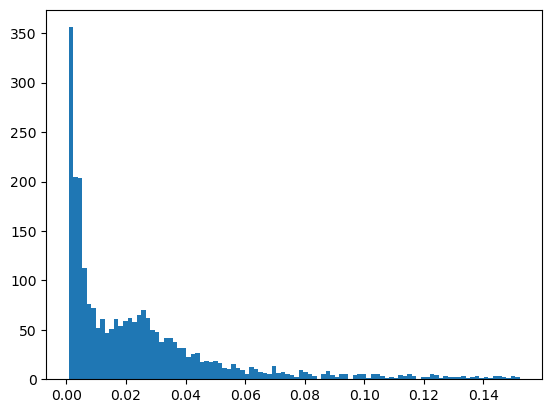

In [ ]:
plt.figure()
plt.hist(V1_pRF_normalized.flatten(), bins = 100)
plt.show()

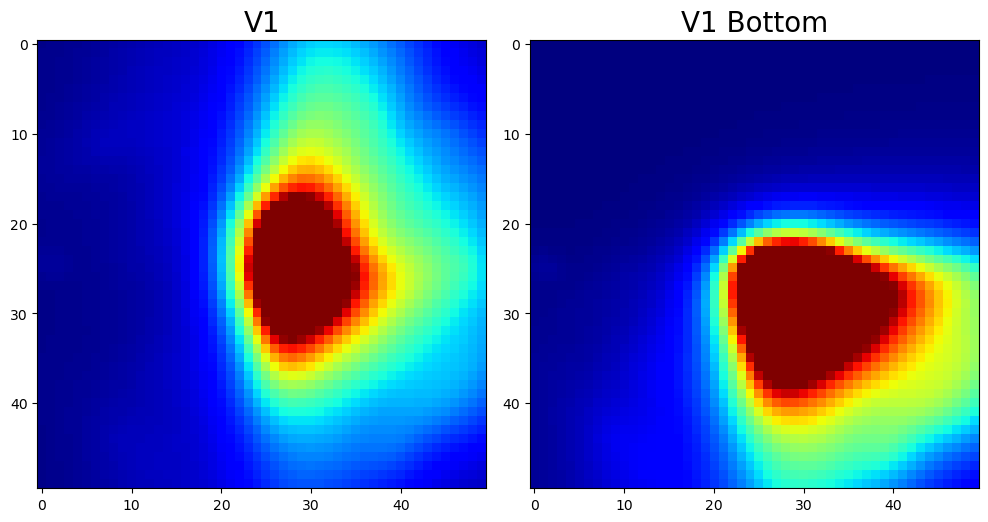

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(V1_pRF_normalized, cmap='jet', interpolation='nearest', vmin = 0, vmax = 0.08)
axs[0].set_title('V1', fontsize=20)
axs[1].imshow(V1bottom_pRF_normalized, cmap='jet', interpolation='nearest', vmin = 0, vmax = 0.08)
axs[1].set_title('V1 Bottom', fontsize=20)
plt.tight_layout()
plt.savefig('/d/DATA/hyper/manuscripts/Dake_Curtis_2024/V1_pRFmap.eps', format = 'eps', dpi = 1200)
plt.show()
# f, axs = plt.subplots(2, 2, figsize=(10, 10))
# axs = axs.flatten()
# axs[0].imshow(V1_pRF_normalized, cmap='hot', interpolation='nearest')
# axs[0].set_title('V1')
# axs[1].imshow(V2d_pRF_normalized, cmap='hot', interpolation='nearest')
# axs[1].set_title('V2d')
# axs[2].imshow(V3d_pRF_normalized, cmap='hot', interpolation='nearest')
# axs[2].set_title('V3d')
# axs[3].imshow(V3AB_pRF_normalized, cmap='hot', interpolation='nearest')
# axs[3].set_title('V3AB')
# plt.tight_layout()
# plt.show()

In [ ]:
plt.figure()
y = np.mean(Efield_holder, 0)
plt.plot(y * np.cos(np.deg2rad(bin_middles)), y * np.sin(np.deg2rad(bin_middles)), 'k*')
plt.xlim([-0.3, 0.3])
plt.ylim([-0.3, 0.3])
# # y_err = np.nanstd(Efield_holder, 0)/np.sqrt(len(temp_subs))
# plt.plot(bin_middles, y, 'k')

# plt.fill_between(bin_middles, y-y_err, y+y_err, alpha=0.5, linewidth=0, color='k')

# # plt.axvline(0-polang_range_holder.max()/2, color = 'r', linestyle = '--')
# # plt.axvline(0+polang_range_holder.max()/2, color = 'r', linestyle = '--')
# # plt.axvspan(-np.mean(polang_range_holder)/2, np.mean(polang_range_holder)/2, color='blue', alpha=0.3)
# # plt.axvspan(-90-np.mean(polang_range_holder)/2, -90+np.mean(polang_range_holder)/2, color='red', alpha=0.3)

# plt.axvspan(-np.max(polang_range_holder)/2, np.max(polang_range_holder)/2, color='blue', alpha=0.3)
# plt.axvspan(-90-np.max(polang_range_holder)/2, -90+np.max(polang_range_holder)/2, color='red', alpha=0.3)
# # for idx, sub in enumerate(temp_subs):
# #     plt.plot(polang_range_holder[idx], 0, 'r-')
# plt.xlabel('Polar Angle (degrees)')
# plt.ylabel('Normalized E-field')
# plt.xlim([-180, 180])
# plt.xticks([-180, -135, -90, -45, 0, 45, 90, 135, 180])
# plt.title('E-field Magnitude by Polar Angle Bin')
# plt.savefig('/d/DATA/hyper/manuscripts/Dake_Curtis_2024/predicted_efield_peak.eps', format = 'eps', dpi = 1200)
plt.show()

In [ ]:
temp_subs = [1, 3, 5, 6, 7, 10, 12, 14, 15, 17, 22, 23, 25, 26, 27]
sess = [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
loc = [1, 2, 8, 3, 4, 6, 4, 6, 5, 2, 6, 3, 4, 1, 4]
n_subs = len(temp_subs)

fig, axs = plt.subplots(n_subs, 2, figsize=(10, 5 * n_subs))
for idx, sub in enumerate(temp_subs):
    sub_id = f"sub{sub:02d}"
    metric = "magnE"
    this_hemi = hemisphere_stimulated[idx]

    subfoldpath = f"{p['simnibs_path']}/{sub_id}"
    m2mfoldpath = f"{subfoldpath}/m2m_{sub_id}"
    simfoldpath = f"{subfoldpath}/simstandard/subject_volumes/Targets-0001_MagVenture_Cool-B70_scalar_"
    metricfile = f"{simfoldpath}{metric}.nii.gz"
    sub_init = All_metadata[sub]['Subject Initials']
    if sub == 12:
        funcFitpath = f"/d/DATA/data/pRF_subjects/{sub_init}/RF1/{sub_init}_RF1_vista/Inplane/Original/RF_ss5_25mm-fFit.nii.gz"
    elif sub == 26: 
        funcFitpath = f"/d/DATA/data/pRF_subjects/{sub_init}/RF1/{sub_init}_RF1_vista/Inplane/Original/RF_ss5_25mm-fFit.nii.gz"
    else:
        funcFitpath = f"/d/DATA/data/pRF_subjects/{sub_init}/RF1/{sub_init}_RF1_vista/Inplane/Original/RF_ss5-fFit.nii.gz"
        
    if this_hemi ==  'Left':
        file_paths = {
            'T1': f"{subfoldpath}/T1.nii",
            'lhV1': f"{subfoldpath}/lh.V1.nii.gz",
            'rhV1': f"{subfoldpath}/rh.V1.nii.gz",
            'lhV2d': f"{subfoldpath}/lh.V2d.nii.gz",
            'rhV2d': f"{subfoldpath}/rh.V2d.nii.gz",
            'lhV3d': f"{subfoldpath}/lh.V3d.nii.gz",
            'rhV3d': f"{subfoldpath}/rh.V3d.nii.gz",
            'lhV3AB': f"{subfoldpath}/lh.V3AB.nii.gz",
            'rhV3AB': f"{subfoldpath}/rh.V3AB.nii.gz"
        }
    else:
        file_paths = {
            'T1': f"{subfoldpath}/T1.nii",
            'lhV1': f"{subfoldpath}/rh.V1.nii.gz",
            'rhV1': f"{subfoldpath}/lh.V1.nii.gz",
            'lhV2d': f"{subfoldpath}/rh.V2d.nii.gz",
            'rhV2d': f"{subfoldpath}/lh.V2d.nii.gz",
            'lhV3d': f"{subfoldpath}/rh.V3d.nii.gz",
            'rhV3d': f"{subfoldpath}/lh.V3d.nii.gz",
            'lhV3AB': f"{subfoldpath}/rh.V3AB.nii.gz",
            'rhV3AB': f"{subfoldpath}/lh.V3AB.nii.gz"
        }
    
    funcFitdata = load_nii_file(funcFitpath, file_paths['T1'])
    # Remove voxels below variance-explained threshold of 0.1
    ve_thresh = 0.1
    bad_voxels = np.where(funcFitdata[:, :, :, 1] < ve_thresh)
    polmap_data = funcFitdata[:, :, :, 0]
    polmap_data[bad_voxels] = np.nan
    polmap_data = np.rad2deg(polmap_data)

    # Change the polar angle coordinate space to match the coordinate space used in behavior
    polmap_data[(polmap_data>=0) & (polmap_data<=180)] = -polmap_data[(polmap_data>=0) & (polmap_data<=180)]
    polmap_data[(polmap_data>180) & (polmap_data<360)] = 360-polmap_data[(polmap_data>180) & (polmap_data<360)]
    #t1_data = nib.load(t1_path).get_fdata()
    metric_data = load_nii_file(metricfile, file_paths['T1'])
    lhV1_data = load_nii_file(file_paths['lhV1'], file_paths['T1'])
    rhV1_data = load_nii_file(file_paths['rhV1'], file_paths['T1'])
    lhV2d_data = load_nii_file(file_paths['lhV2d'], file_paths['T1'])
    rhV2d_data = load_nii_file(file_paths['rhV2d'], file_paths['T1'])
    lhV3d_data = load_nii_file(file_paths['lhV3d'], file_paths['T1'])
    rhV3d_data = load_nii_file(file_paths['rhV3d'], file_paths['T1'])
    lhV3AB_data = load_nii_file(file_paths['lhV3AB'], file_paths['T1'])
    rhV3AB_data = load_nii_file(file_paths['rhV3AB'], file_paths['T1'])
    totalV1_data = ((lhV1_data == 1) | (rhV1_data == 1)).astype(int)
    totalV_data = ((lhV1_data == 1) | (rhV1_data == 1) | (lhV2d_data == 1) | (rhV2d_data == 1) | (lhV3d_data == 1) | (rhV3d_data == 1) | (lhV3AB_data == 1) | (rhV3AB_data == 1)).astype(int)
    normalize_Efield = metric_data/metric_data.max()

    polmap_data_flat = polmap_data.flatten()
    totalV_data_flat = totalV_data.flatten() 
    polmap_data_flat[totalV_data_flat != 1] = np.nan
    normalize_Efield_flat = normalize_Efield.flatten()
    valid_indices = ~np.isnan(polmap_data_flat)
    polmap_data_valid = polmap_data_flat[valid_indices]
    normalize_Efield_valid = normalize_Efield_flat[valid_indices]

    polar_angle_bins = np.linspace(min(polmap_data_valid), max(polmap_data_valid), num=100)  
    polar_angle_bin_indices = np.digitize(polmap_data_valid, polar_angle_bins)

    # Calculate the mean E-field magnitude for each bin
    mean_efield_per_bin = np.array([normalize_Efield_valid[polar_angle_bin_indices == i].mean() for i in range(1, len(polar_angle_bins))])
    mean_efield_per_bin = np.nan_to_num(mean_efield_per_bin)
    bin_middles = (polar_angle_bins[:-1] + polar_angle_bins[1:]) / 2
    x_plot = mean_efield_per_bin * np.cos(np.deg2rad(bin_middles))
    y_plot = mean_efield_per_bin * np.sin(np.deg2rad(bin_middles))

    axs[idx, 0].plot(x_plot, y_plot, 'b--')
    axs[idx, 0].set_xlim([-np.max(mean_efield_per_bin), np.max(mean_efield_per_bin)])
    axs[idx, 0].set_ylim([-np.max(mean_efield_per_bin), np.max(mean_efield_per_bin)])
    axs[idx, 0].set_title(f"Predicted E-field: {sub_id}")

    phosphPath = f"{p['data']}/phosphene_data/{sub_id}/PhospheneReport_{sub_id}_sess{sess[idx]:02d}_antitype_mirror.mat"
    actual_pmap = loadmat(phosphPath)['PhosphReport'][0, loc[idx]-1]['StimuliSampleSpace'].astype(np.float64)
    xpix_max = 1920
    ypix_max = 1080
    actual_pmap[:, 0] = (actual_pmap[:, 0] - xpix_max/2)/xpix_max
    actual_pmap[:, 1] = (actual_pmap[:, 1] - ypix_max/2)#/xpix_max
    actual_pmap[:, 1] = (- actual_pmap[:, 1])/ypix_max
    # if this_hemi == 'Left':
    axs[idx, 1].plot(actual_pmap[:, 0], actual_pmap[:, 1], 'k*', label='inPF')
    axs[idx, 1].plot(-actual_pmap[:, 0], actual_pmap[:, 1], 'r*', label='outPF')
    # else:
    #     axs[idx, 1].plot(-actual_pmap[:, 0], actual_pmap[:, 1], 'k*', label='inPF')
    #     axs[idx, 1].plot(actual_pmap[:, 0], actual_pmap[:, 1], 'r*', label='outPF')
    axs[idx, 1].set_xlim([-1/2, 1/2])
    axs[idx, 1].set_ylim([-1/2, 1/2])
    axs[idx, 1].legend()
    axs[idx, 1].set_title('Actual stimulus location')
plt.show()

In [ ]:
temp_subs = [1, 3, 5, 6, 7, 10, 14, 15, 17, 22, 23, 25, 27]
#temp_subs = [1, 3, 5]
# sess = [1, 2, 1]
# loc = [1, 2, 8]

sess = [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
loc = [1, 2, 8, 3, 4, 6, 6, 5, 2, 6, 3, 4, 4]
n_subs = len(temp_subs)
# n_rows = round(n_subs)

fig, axs = plt.subplots(n_subs, 4, figsize=(20, 5 * n_subs))
for idx, sub in enumerate(temp_subs):
    sub_id = f"sub{sub:02d}"
    metric = "magnE"
    this_hemi = hemisphere_stimulated[idx]

    subfoldpath = f"{p['simnibs_path']}/{sub_id}"
    m2mfoldpath = f"{subfoldpath}/m2m_{sub_id}"
    simfoldpath = f"{subfoldpath}/simstandard/subject_volumes/Targets-0001_MagVenture_Cool-B70_scalar_"
    metricfile = f"{simfoldpath}{metric}.nii.gz"
    sub_init = All_metadata[sub]['Subject Initials']
    funcFitpath = f"/d/DATA/data/pRF_subjects/{sub_init}/RF1/{sub_init}_RF1_vista/Inplane/Original/RF_ss5-fFit.nii.gz"
        
    if this_hemi ==  'Left':
        file_paths = {
            'T1': f"{subfoldpath}/T1.nii",
            'lhV1': f"{subfoldpath}/lh.V1.nii.gz",
            'rhV1': f"{subfoldpath}/rh.V1.nii.gz",
            'lhV2d': f"{subfoldpath}/lh.V2d.nii.gz",
            'rhV2d': f"{subfoldpath}/rh.V2d.nii.gz",
            'lhV3d': f"{subfoldpath}/lh.V3d.nii.gz",
            'rhV3d': f"{subfoldpath}/rh.V3d.nii.gz",
            'lhV3AB': f"{subfoldpath}/lh.V3AB.nii.gz",
            'rhV3AB': f"{subfoldpath}/rh.V3AB.nii.gz"
        }
    else:
        file_paths = {
            'T1': f"{subfoldpath}/T1.nii",
            'lhV1': f"{subfoldpath}/rh.V1.nii.gz",
            'rhV1': f"{subfoldpath}/lh.V1.nii.gz",
            'lhV2d': f"{subfoldpath}/rh.V2d.nii.gz",
            'rhV2d': f"{subfoldpath}/lh.V2d.nii.gz",
            'lhV3d': f"{subfoldpath}/rh.V3d.nii.gz",
            'rhV3d': f"{subfoldpath}/lh.V3d.nii.gz",
            'lhV3AB': f"{subfoldpath}/rh.V3AB.nii.gz",
            'rhV3AB': f"{subfoldpath}/lh.V3AB.nii.gz"
        }
    
    funcFitdata = load_nii_file(funcFitpath, file_paths['T1'])
    # Remove voxels below variance-explained threshold of 0.1
    ve_thresh = 0.1
    bad_voxels = np.where(funcFitdata[:, :, :, 1] < ve_thresh)
    polmap_data = funcFitdata[:, :, :, 0]
    polmap_data[bad_voxels] = np.nan
    polmap_data = np.rad2deg(polmap_data)

    # Change the polar angle coordinate space to match the coordinate space used in behavior
    polmap_data[(polmap_data>=0) & (polmap_data<=180)] = -polmap_data[(polmap_data>=0) & (polmap_data<=180)]
    polmap_data[(polmap_data>180) & (polmap_data<360)] = 360-polmap_data[(polmap_data>180) & (polmap_data<360)]
    #t1_data = nib.load(t1_path).get_fdata()
    metric_data = load_nii_file(metricfile, file_paths['T1'])
    lhV1_data = load_nii_file(file_paths['lhV1'], file_paths['T1'])
    rhV1_data = load_nii_file(file_paths['rhV1'], file_paths['T1'])
    lhV2d_data = load_nii_file(file_paths['lhV2d'], file_paths['T1'])
    rhV2d_data = load_nii_file(file_paths['rhV2d'], file_paths['T1'])
    lhV3d_data = load_nii_file(file_paths['lhV3d'], file_paths['T1'])
    rhV3d_data = load_nii_file(file_paths['rhV3d'], file_paths['T1'])
    lhV3AB_data = load_nii_file(file_paths['lhV3AB'], file_paths['T1'])
    rhV3AB_data = load_nii_file(file_paths['rhV3AB'], file_paths['T1'])
    totalV1_data = ((lhV1_data == 1) | (rhV1_data == 1)).astype(int)
    totalV_data = ((lhV1_data == 1) | (rhV1_data == 1) | (lhV2d_data == 1) | (rhV2d_data == 1) | (lhV3d_data == 1) | (rhV3d_data == 1) | (lhV3AB_data == 1) | (rhV3AB_data == 1)).astype(int)
    normalize_Efield = metric_data/metric_data.max()

    polmap_data_flat = polmap_data.flatten()
    totalV_data_flat = totalV_data.flatten() 
    polmap_data_flat[totalV_data_flat != 1] = np.nan
    normalize_Efield_flat = normalize_Efield.flatten()
    valid_indices = ~np.isnan(polmap_data_flat)
    polmap_data_valid = polmap_data_flat[valid_indices]
    normalize_Efield_valid = normalize_Efield_flat[valid_indices]

    polar_angle_bins = np.linspace(min(polmap_data_valid), max(polmap_data_valid), num=180)  
    polar_angle_bin_indices = np.digitize(polmap_data_valid, polar_angle_bins)

    # Calculate the mean E-field magnitude for each bin
    mean_efield_per_bin = np.array([normalize_Efield_valid[polar_angle_bin_indices == i].mean() for i in range(1, len(polar_angle_bins))])
    mean_efield_per_bin = np.nan_to_num(mean_efield_per_bin)
    bin_middles = (polar_angle_bins[:-1] + polar_angle_bins[1:]) / 2
    x_plot = mean_efield_per_bin * np.cos(np.deg2rad(bin_middles))
    y_plot = mean_efield_per_bin * np.sin(np.deg2rad(bin_middles))

    axs[idx, 0].plot(x_plot, y_plot, 'b--')
    axs[idx, 0].set_xlim([-np.max(mean_efield_per_bin), np.max(mean_efield_per_bin)])
    axs[idx, 0].set_ylim([-np.max(mean_efield_per_bin), np.max(mean_efield_per_bin)])
    axs[idx, 0].set_title('Predicted E-field')

    actual_pmap = loadmat(phosphPath)['PhosphReport'][0, loc[idx]-1]['StimuliSampleSpace'].astype(np.float64)
    xpix_max = 1920
    ypix_max = 1080
    actual_pmap[:, 0] = (actual_pmap[:, 0] - xpix_max/2)/xpix_max
    actual_pmap[:, 1] = (actual_pmap[:, 1] - ypix_max/2)#/xpix_max
    actual_pmap[:, 1] = (- actual_pmap[:, 1])/ypix_max
    axs[idx, 1].plot(actual_pmap[:, 0], actual_pmap[:, 1], 'k*', label='inPF')
    axs[idx, 1].plot(-actual_pmap[:, 0], actual_pmap[:, 1], 'r*', label='outPF')
    axs[idx, 1].set_xlim([-1/2, 1/2])
    axs[idx, 1].set_ylim([-1/2, 1/2])
    axs[idx, 1].legend()
    axs[idx, 1].set_title('Actual stimulus location')

    df_tms = df_calib_all5_filt[(df_calib_all5_filt['subjID']==sub) & (df_calib_all5_filt['day']==4) & (df_calib_all5_filt['istms']==1) & (df_calib_all5_filt['ispro']==1)]
    df_notms = df_calib_all5_filt[(df_calib_all5_filt['subjID']==sub) & (df_calib_all5_filt['day']<4) & (df_calib_all5_filt['istms']==0) & (df_calib_all5_filt['ispro']==1)]
    tms_polang = np.rad2deg(df_tms['polang'])
    notms_polang = np.rad2deg(df_notms['polang'])
    tms_err = df_tms['ierr']
    notms_err = df_notms['ierr']

    tms_polang_bin_idx = np.digitize(tms_polang, polar_angle_bins)
    notms_polang_bin_idx = np.digitize(notms_polang, polar_angle_bins)
    tms_err_per_bin = np.array([tms_err[tms_polang_bin_idx == i].mean() for i in range(1, len(polar_angle_bins))])
    tms_err_per_bin = np.nan_to_num(tms_err_per_bin)
    notms_err_per_bin = np.array([notms_err[notms_polang_bin_idx == i].mean() for i in range(1, len(polar_angle_bins))])
    notms_err_per_bin = np.nan_to_num(notms_err_per_bin)
    rel_err_per_bin = np.divide((tms_err_per_bin-notms_err_per_bin), notms_err_per_bin, where=notms_err_per_bin!=0)

    x_err = tms_err_per_bin * np.cos(np.deg2rad(bin_middles))
    y_err = tms_err_per_bin * np.sin(np.deg2rad(bin_middles))
    axs[idx, 2].plot(x_err, y_err, 'r--', label='TMS')
    x_err = notms_err_per_bin * np.cos(np.deg2rad(bin_middles))
    y_err = notms_err_per_bin * np.sin(np.deg2rad(bin_middles))
    axs[idx, 2].plot(x_err, y_err, 'b--', label='No TMS')
    axs[idx, 2].set_xlim([-np.nanmax(tms_err_per_bin), np.nanmax(tms_err_per_bin)])
    axs[idx, 2].set_ylim([-np.nanmax(tms_err_per_bin), np.nanmax(tms_err_per_bin)])
    axs[idx, 2].legend()
    axs[idx, 2].set_title('Early vs NoTMS')

    df_tms = df_calib_all5_filt[(df_calib_all5_filt['subjID']==sub) & (df_calib_all5_filt['day']<4) & (df_calib_all5_filt['istms']==1) & (df_calib_all5_filt['ispro']==1)]
    df_notms = df_calib_all5_filt[(df_calib_all5_filt['subjID']==sub) & (df_calib_all5_filt['day']<4) & (df_calib_all5_filt['istms']==0) & (df_calib_all5_filt['ispro']==1)]
    tms_polang = np.rad2deg(df_tms['polang'])
    notms_polang = np.rad2deg(df_notms['polang'])
    tms_err = df_tms['ierr']
    notms_err = df_notms['ierr']

    tms_polang_bin_idx = np.digitize(tms_polang, polar_angle_bins)
    notms_polang_bin_idx = np.digitize(notms_polang, polar_angle_bins)
    tms_err_per_bin = np.array([tms_err[tms_polang_bin_idx == i].mean() for i in range(1, len(polar_angle_bins))])
    tms_err_per_bin = np.nan_to_num(tms_err_per_bin)
    notms_err_per_bin = np.array([notms_err[notms_polang_bin_idx == i].mean() for i in range(1, len(polar_angle_bins))])
    notms_err_per_bin = np.nan_to_num(notms_err_per_bin)
    rel_err_per_bin = np.divide((tms_err_per_bin-notms_err_per_bin), notms_err_per_bin, where=notms_err_per_bin!=0)

    x_err = tms_err_per_bin * np.cos(np.deg2rad(bin_middles))
    y_err = tms_err_per_bin * np.sin(np.deg2rad(bin_middles))
    axs[idx, 3].plot(x_err, y_err, 'r--', label='TMS')
    x_err = notms_err_per_bin * np.cos(np.deg2rad(bin_middles))
    y_err = notms_err_per_bin * np.sin(np.deg2rad(bin_middles))
    axs[idx, 3].plot(x_err, y_err, 'b--', label='No TMS')
    axs[idx, 3].set_xlim([-np.nanmax(tms_err_per_bin), np.nanmax(tms_err_per_bin)])
    axs[idx, 3].set_ylim([-np.nanmax(tms_err_per_bin), np.nanmax(tms_err_per_bin)])
    axs[idx, 3].legend()
    axs[idx, 3].set_title('Middle vs NoTMS')
plt.show()

In [ ]:
slice_x = 1
slice_y = 1
slice_z = 1
slice_m = 0
polmap_to_plot = polmap_data.copy()
polmap_to_plot[(polmap_to_plot > 0) & (polmap_to_plot < np.pi)] = np.nan
def update_plot(slice_x, slice_y, slice_z):
    plt.figure(figsize=(15, 15))
    # Subplot for slice_x
    plt.subplot(231)
    plt.imshow(t1_data[:, slice_x, :], cmap='gray', origin='lower')
    plt.title(f'Slice X: {slice_x}')
    plt.axis('off')
    # Subplot for slice_y
    plt.subplot(232)
    plt.imshow(t1_data[slice_y, :, :], cmap='gray', origin='lower')
    plt.title(f'Slice Y: {slice_y}')
    plt.axis('off')
    # Subplot for slice_z
    plt.subplot(233)
    plt.imshow(t1_data[:, :, slice_z], cmap='gray', origin='lower')
    plt.title(f'Slice Z: {slice_z}')
    plt.axis('off')

    plt.subplot(234)
    plt.imshow(polmap_to_plot[:, slice_x, :], cmap='inferno', origin='lower')
    plt.title(f'Slice X: {slice_x}')
    plt.axis('off')
    # Subplot for slice_y
    plt.subplot(235)
    plt.imshow(polmap_to_plot[slice_y, :, :], cmap='inferno', origin='lower')
    plt.title(f'Slice Y: {slice_y}')
    plt.axis('off')
    # Subplot for slice_z
    plt.subplot(236)
    plt.imshow(polmap_to_plot[:, :, slice_z], cmap='inferno', origin='lower')
    plt.title(f'Slice Z: {slice_z}')
    plt.axis('off')

    plt.show()
# Create widgets for each slice
slice_x_widget = widgets.IntSlider(min=0, max=t1_data.shape[0] - 1, value=slice_x, description='Slice X:')
slice_y_widget = widgets.IntSlider(min=0, max=t1_data.shape[1] - 1, value=slice_y, description='Slice Y:')
slice_z_widget = widgets.IntSlider(min=0, max=t1_data.shape[2] - 1, value=slice_z, description='Slice Z:')
# Create an interactive plot
interact(update_plot, slice_x=slice_x_widget, slice_y=slice_y_widget, slice_z=slice_z_widget)

In [ ]:
# df_tms = df_calib_all5_filt[(df_calib_all5_filt['subjID']==27) & (df_calib_all5_filt['istms']==1) & (df_calib_all5_filt['instimVF']==1)]
# df_notms = df_calib_all5_filt[(df_calib_all5_filt['subjID']==27) & (df_calib_all5_filt['istms']==1) & (df_calib_all5_filt['instimVF']==0)]
df_tms = df_calib_all5_filt[(df_calib_all5_filt['hemistimulated']=='Left') & (df_calib_all5_filt['istms']==1) & (df_calib_all5_filt['instimVF']==1)]
df_notms = df_calib_all5_filt[(df_calib_all5_filt['hemistimulated']=='Left') & (df_calib_all5_filt['istms']==1) & (df_calib_all5_filt['instimVF']==0)]
tms_polang = np.rad2deg(df_tms['polang'])
tms_err = df_tms['ierr']
notms_polang = np.rad2deg(df_notms['polang'])
notms_err = df_notms['ierr']
nbins = 20
min_pol = np.min(tms_polang)
max_pol = np.max(tms_polang)
bins = np.linspace(min_pol, max_pol, nbins+1) 

# Mirror these polar angles across the vertical meridian
# notms_polang_mirrored = np.where((tms_polang >= 0) & (tms_polang <= 180), -tms_polang, 
#                                  np.where((tms_polang < 0) & (tms_polang >= -180), abs(tms_polang), tms_polang))
# notms_polang_mirrored = np.where(notms_polang_mirrored == -180, 180, notms_polang_mirrored)
notms_polang_mirrored = np.where((notms_polang >= 0) & (notms_polang <= 180), 180-notms_polang, 
                                 np.where((notms_polang < 0) & (notms_polang >= -180), -(180-np.abs(notms_polang)), notms_polang))

tms_bin_indices = np.digitize(tms_polang, bins)
notms_bin_indices = np.digitize(notms_polang_mirrored, bins, right=True)

df_tms['bin'] = tms_bin_indices
df_notms['bin'] = notms_bin_indices

mean_tms_err_per_bin = df_tms.groupby('bin')['ierr'].mean()
mean_notms_err_per_bin = df_notms.groupby('bin')['ierr'].mean()

bins_df = pd.DataFrame(index=range(1, nbins+2))
mean_tms_err_per_bin = bins_df.join(mean_tms_err_per_bin, how='left').fillna(0)
mean_notms_err_per_bin = bins_df.join(mean_notms_err_per_bin, how='left').fillna(0)

comparison_df = pd.DataFrame({
    'bin_edges': bins,
    'mean_tms_err': mean_tms_err_per_bin['ierr'].values,
    'mean_notms_err': mean_notms_err_per_bin['ierr'].values,
    'relative_err': mean_tms_err_per_bin['ierr'].values/mean_notms_err_per_bin['ierr'].values - 1,
})
print(comparison_df)

# f, axs = plt.subplots(2, 1)    
# axs[0].plot(, , 'ro')
# axs[1].plot(, , 'ro')